
## Approach/Potential Outline:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject/body
    1. Number of words in the subject/body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number/percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. Alternatively, identify misclassified emails and see which relevant words are missing in the model.
1. Reducing dimensionality and/or multicollinearity. few methods to achieve this:
    1. Implement PCA.
    1. Interpret the model coefficients. Note that a feature will be more valuable in classification if its coefficient has a larger **absolute** value. If the coefficient has a lower **absolute** value, the feature likely isn't valuable in classifying emails.
1. Better data processing. For example, many emails contain HTML as well as text.  Extracting the text from the HTML to help  find better words. Or can match HTML tags themselves, or even some combination of the two.
1. Model selection. Adjust the parameters of the model (e.g. the penalty type, the regularization parameter, or any arguments in `LogisticRegression`) to achieve higher accuracy.  Should be using cross-validation for feature and model selection! Otherwise, it will likely overfit to the training data.
    1. Implementing L1 regularization. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for `LogisticRegression` may be helpful here. 
    1. imported `GridSearchCV`and use sklearn's `GridSearchCV` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) class to perform cross-validation. 


**Note 1:** use the **validation data** to evaluate the model and get a better sense of how it will perform on the test set. However,  overfiting to in the validation set if it try to optimize the validation accuracy too much. Alternatively, can perform cross-validation on the entire training set.

In [36]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

## Loading and Cleaning Data


In [37]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [38]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [39]:
# Fill any missing or NAN values.
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


## Training/Validation Split


In [40]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts.
train = train.reset_index(drop = True)

## Feature Engineering


In [41]:
from projB2_utils import words_in_texts

words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

## EDA and Basic Classification


In [42]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [43]:
from sklearn.linear_model import LogisticRegression

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train)

training_accuracy = simple_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers


Presumably, the classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:


<center>
<img alt="precision_recall" src="precision_recall.png" width="600px;" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

[Text(0.5, 1.0, 'Features Pairwise Correlations Heatmap')]

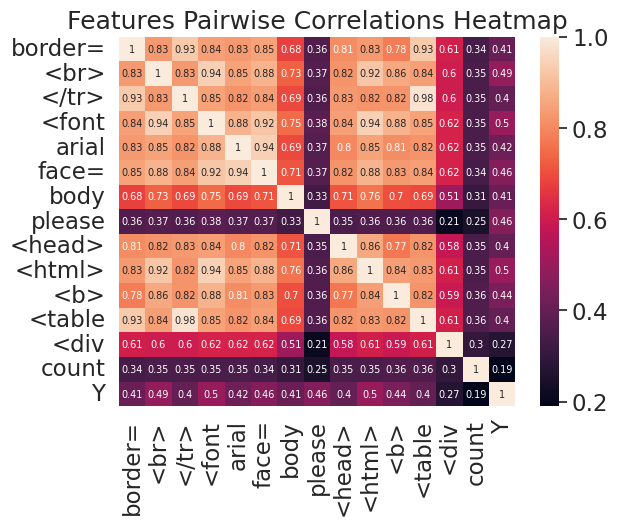

In [44]:
#Visual of each email's count of characters, numbers, symbols, etc...
#Finding better features based on the email text. Some example features are:
#Number of characters in the subject/body
#Number of words in the subject/body
#Use of punctuation (e.g., how many '!'s were there?)
#Number/percentage of capital letters
#Whether the email is a reply to an earlier email or a forwarded email
words = ['border=', '<br>', '</tr>', '<font', 'arial', 'face=','body','please','<head>','<html>', '<b>', '<table', '<div'] 
X_train_vis = words_in_texts(words, train['email'])
X_df = pd.DataFrame(columns = words)
for i, row in enumerate(X_train_vis):
    X_df.loc[i] = row
X_df['count'] = train['email'].str.count('!')
X_df['Y'] = train['spam']
display(sns.heatmap(data = np.round(X_df.corr(), 2), annot = True, annot_kws = {'size':7}).set(title='Features Pairwise Correlations Heatmap'))

Text(0, 0.5, 'Average Count of !')

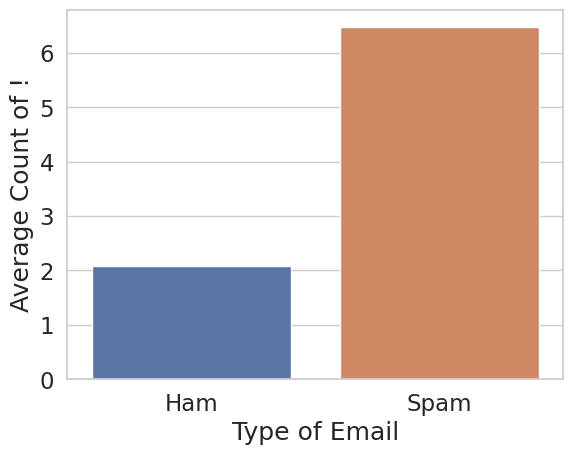

In [45]:
bar = train['email'].str.count('!').groupby(train['spam']).mean().to_frame().reset_index()
bar = bar.replace({0:'Ham', 1:'Spam'})
sns.barplot(data = bar,x = 'spam', y = 'email')
plt.xlabel('Type of Email')
plt.ylabel('Average Count of !')

From the heatmap plotted above we can observe that common html tags are associated not only with other html tags but also with determining our response variable 'spam'. The second barplot plots the count of exclamations in each ham and spam email texts, proving that exclamation points are on average more prevalent within spam emails than ham. 



<br/>
<hr style="border: 1px solid #fdb515;" />

# Building Own Model!



In [46]:
train[train['spam'] == 1][40:60].head()

,id,subject,email,spam
133,7486,Subject: []ε ޾ƺ\n,<!-- saved from url=3d(0022)http://internet.e-...,1
134,4126,Subject: ****Already own a satellite? Need a ...,recieve all channels on your satellite system!...,1
138,1087,Subject: FREE Cell Phone + $50 Cash Back!\n,<html><head><title>free motorola cell phone wi...,1
144,3303,Subject: Thanksgiving Sale\n,\n this is a multi-part message in mime format...,1
145,17,Subject: National Charity Suffering Since 9/11\n,<body bgcolor=#ffffff>\n <div><font face=arial...,1


In [47]:
# import libraries
# You may use any of these to create features.
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import re
from collections import Counter

In [48]:
print('Ham Replies Prop: ', train.loc[(train['subject'].str.contains('Re:')) & train['spam'] == 0,:].count()[1]/train.shape[0])
print('Spam Replies Prop: ', train.loc[(train['subject'].str.contains('Re:')) & train['spam'] == 1,:].count()[1]/train.shape[0])

Ham Replies Prop:  0.9912152269399708
Spam Replies Prop:  0.008784773060029283


In [49]:
X_df = train.copy()
#train['email'].str.count(r'/?[2]').groupby(train['spam']).mean().to_frame()
#X_df['has reply'] = train['subject'].str.contains(r'Subject:\s(Re:)\s', regex= True)
X_df['X_prop'] = (X_df['subject'].str.count(r'[A-Z]')/(X_df['subject'].str.strip(' ').str.len()))
X_df
np.mean(X_df[X_df['spam'] ==True]['X_prop'])

0.16631139763467886

In [50]:
# Define  processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!
def feature_process(df):
    words = ['border=', '<br>', '</tr>', '<font','arial', 'face=','body','please','<head>','<html>', '<b>',  '<table','<div',
         '<p', 'sans-serif', 'free', 'cash', 
             'offer', 'business', 'verdana', '<option', 'address', 'need', 'money', 'credit card', '<center', 'align=', 'emailing list',
            'urgent', 'dear', 'congratulation', 'dollar', 'confidential', 'drug']
    X = words_in_texts(words, df['email'])
    X_reg = pd.DataFrame(X,columns = words)
    #for i, row in enumerate(X):
        #X_reg.loc[i] = row
## Add additional Features below this 
    X_reg['net_sub'] =  df['subject'].str.findall(r'[!=&;$%#"]').str.len().fillna(0)
    X_reg['net_email'] =  df['email'].str.findall(r'[!=&;$#<]').str.len().fillna(0)
    X_reg['multi_dashes'] =  df['email'].str.findall(r'/-{3,}').str.len().fillna(0)
    X_reg['repeating_chars'] =  df['email'].str.findall(r'/[a-z]{5,}').str.len().fillna(0)
    X_reg['text_text'] = df['email'].str.split(' ').str.len()/df['email'].str.len().fillna(0)
    X_reg['text_subject'] = df['subject'].str.split(' ').str.len().fillna(0)
    X_reg['Is Reply'] = df['subject'].str.contains(r'\Subject: Re:', regex= True).fillna(0)
    avg = np.mean((df['subject'].str.count(r'[A-Z]')/df['subject'].str.len())**2)
    #X_reg['Capital'] = ((df['subject'].str.count(r'[A-Z]')/df['subject'].str.strip(' ').str.len())**2).fillna(avg)
    X_reg['shouting'] = ((df['subject'].str.count(r'[A-Z]')/df['subject'].str.strip(' ').str.len())**2).fillna(avg)
    #X_reg['Capital'] = df['Capital'].fillna(np.mean(X_reg['Capital']))
    sub_list = ['please', 'address', 'money', 'time', 'free', '$', 'email', 'credit card', ' need', 'information', '#', 'asap', 'assistance',
               '"', 'urgent', 'need', 'cash', 'congrats', 'congratulation']
    X_sub = words_in_texts(sub_list, df['subject'].str.lower())
    X_sub_df = pd.DataFrame(X_sub, columns =sub_list)
    #for i, row in enumerate(X_sub):
    #    X_sub_df.loc[i] = row
    #return X_reg.merge(X_sub_df)
    return X_reg.merge(X_sub_df, left_index=True, right_index=True, how='left').fillna(0)
#-----------------------
 
X_reg = feature_process(train)
simple = LogisticRegression(penalty = 'l1', solver = 'liblinear')
X_reg['Y'] = train['spam']
simple.fit(X_reg.iloc[:,:X_reg.shape[1]-1], X_reg['Y'])

LogisticRegression(penalty='l1', solver='liblinear')

In [62]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# To ignore specific warnings, e.g., ConvergenceWarning
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [63]:
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'saga']}
grid = GridSearchCV(estimator=simple, param_grid=parameters)
grid_result = grid.fit(X_reg.iloc[:,:(X_reg.shape[1]-1)], X_reg['Y'])
grid_result.cv_results_ 

{'mean_fit_time': array([0.002246  , 0.17111087, 0.01595397, 0.78244791]),
 'std_fit_time': array([0.000787  , 0.06369757, 0.02645998, 0.01798326]),
 'mean_score_time': array([0.        , 0.00426412, 0.        , 0.00430465]),
 'std_score_time': array([0.00000000e+00, 2.78523519e-05, 0.00000000e+00, 1.78273019e-04]),
 'param_solver': masked_array(data=['lbfgs', 'liblinear', 'newton-cg', 'saga'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'solver': 'lbfgs'},
  {'solver': 'liblinear'},
  {'solver': 'newton-cg'},
  {'solver': 'saga'}],
 'split0_test_score': array([       nan, 0.92348636,        nan, 0.80705256]),
 'split1_test_score': array([       nan, 0.92880905,        nan, 0.79574185]),
 'split2_test_score': array([       nan, 0.90818363,        nan, 0.80239521]),
 'split3_test_score': array([       nan, 0.92010652,        nan, 0.80159787]),
 'split4_test_score': array([       nan, 0.91011984,        nan, 0.7976032 

In [64]:
train_predictions = simple.predict(feature_process(train))

# Print  training accuracy. 
training_accuracy = np.mean(train_predictions == train["spam"])
training_accuracy

0.9241315053906562


## Test Predictions on Test Set (Unlabeled)

In [65]:
train.iloc[:,:3]

,id,subject,email
0,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a..."
1,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...
2,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi..."
3,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...
4,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...
...,...,...,...
7508,5734,Subject: [Spambayes] understanding high false ...,">>>>> ""tp"" == tim peters <tim.one@comcast.net>..."
7509,5191,Subject: Reach millions on the internet!!\n,"\n dear consumers, increase your business sale..."
7510,5390,Subject: Facts about sex.\n,\n forwarded-by: flower\n \n did you know that...
7511,860,Subject: Re: Zoot apt/openssh & new DVD playin...,"on tue, oct 08, 2002 at 04:36:13pm +0200, matt..."


In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,:3], train['spam'], test_size = .33,
                                                            random_state = 42)
test_predictions = simple.predict(feature_process(X_test))
np.mean(test_predictions == y_test)

0.8471774193548387

In [67]:
test_predictions = simple.predict(feature_process(test))
# np.mean(test_predictions == test['spam'])

In [68]:
# Assuming that the predictions on the test set are stored in a 1-dimensional array called
# test_predictions. 
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download test prediction <a href='" + filename + "' download>here</a>."))

Created a CSV file: submission_20241118_000602.csv.


<!-- BEGIN QUESTION -->

<br>

---

# Analysis/ Key Takeaways


1. How did better features worked for the  model?
2. What worked and didnt?
3. Surprising findings?

1.) My model progressively reduced its error and increased its accuracy as I implemented more general html tags that I found are common in programming along with perfroming EDA such as counting the unique values of each word/tag split by spaces and sentence ending characters (.!,:, etc..). From this EDA and filtering for spam email I was able to gain a good understadning of what sort of words/tags spam emails tend to contain outside of commonly used words that overlap both types of emails such as 'the', 'of'. The heat map derived above also provided a good sense to how these different words would perform in our model as we were able to consoliate pairwise correlations which inicated that the html tags correlated highly with not only each other but with the our response variable too ('spam'). Taking the suggestions offered above I also performed regex parsing to count characters such as !,#,-,&,= as I found these to common amongst spam emails, especially groups of them which signaled my capture groups being multiples of these aggregated counts. Additionally, I applied our words_in_texts function to the subject column and merged that to act as another set of features (although it did not contribute much). Furthermore, I added a column that distinguished reply emails emails versus regular emails. Lastly, the behavior of different characters was key to allude spam emails, thus I computed the ratio of capital letters versus total characters and found that spam emails contained higher ratios than ham emails (i.e spam emails and subjects tended to be more in a "shouting" tone). All in all, the key features that mitigated overlap and helped with interpretibility of the model was the incorportation of excessive symbols and html tags in the model as it was highly correlated with accurately distinguishing.

2.) Commonly used overlapping words tended to disprupt the accuracy, thus calling for adjustments and removals of my words list by steering away from commonly used vocabulary. Adding the < against the html tags helped ensure we were indeed targeting the html commands prevalent amongst spam emails. I was initially for looping an enumerated matrix into a data frame which took a long execution time, thus I adjusted and was able to input the matrix directly into a df as entries with the corresponding columns without perfromance errors. The regression would fail when Nan values were encountered during the feature process, thus ensuring the Na values were imputed was a major step. 

3.) I was surprised at the excessive use of symbols and html commands used in spam emails. Additionally I realized the majority of replied emails were practically regular ham emails and were almost never replies. Upon computing the feature of the ratio of upper case letters versus all letters in the subject columns, I was intrigued to find that raising the value by 2 improved the accuracy of the model. On a final note of this feature, the feature contribution was significantly more notable than if I had not computed the ratio and simply processed the sole count. 


# Prediction Performance Evaluation with ROC Curve

In most cases, we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late. In contrast, a patient can receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a particular class. To classify an example, we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, **we can adjust that cutoff threshold**. We can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example.


In [69]:
train1 = feature_process(train)

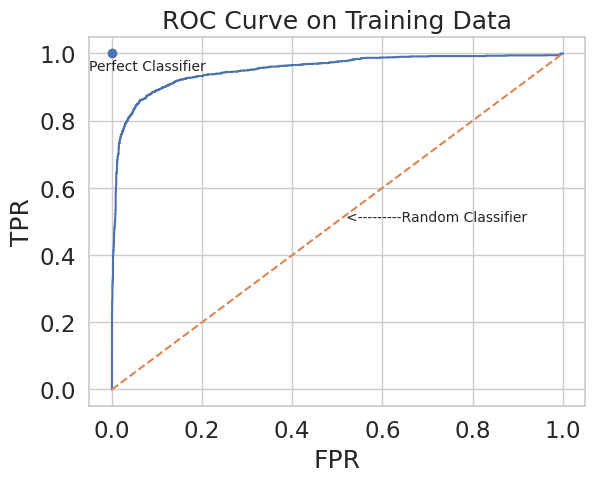

In [70]:
fpr, tpr, t = roc_curve(train['spam'], simple.predict_proba(train1)[:,1])
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, label = 'Random Classifier', linestyle = 'dashed')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC Curve on Training Data')
plt.text(0.52, 0.5, '<---------Random Classifier', size = 10)
plt.scatter(0,1)
plt.text(-.05, .95, 'Perfect Classifier', size = 10)

plt.show();

### Assessing Example 

In [71]:
# Assessing Example
print("spam: " + str(train.loc[1092]["spam"]))
print("\nemail:\n" + train.loc[1092]["email"])

spam: 0

email:
this is a multi part message in mime format.
 
 --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv
 content-type: text/plain; charset="us-ascii"
 content-transfer-encoding: 7bit
 
 ........... with our telecoms partner bumblebee !
 
 don't get ripped off by expensive hotel, payphone and mobile charges. 
 save, save, save on international calls with ryanair's phone partner. 
 ************************************************************************
 *********
 
 you'll save up to 70% on international phone calls when you use our 
 online phone card.  you can use the card from any phone in any country 
 you visit and you won't have to worry about high phone charges 
 when you call home or the office.
 
 buying a card couldn't be easier and it's totally secure.  simply go to
 http://www.bumblebeecommunications.com/lowcostcalls/  
  to avail of this special offer for ryanair customers.
 
 it's another great deal from ryanair and our online phone 
 partner, bumblebee communications. 




### Evaluating Examples emails from above 

My classificaton would classify the email as spam due to multiple characteristics that align with what my model was interested in. This email from RyanAir, an airline provider seems to be a promotional email to gain customers on their different credit card branch of business. The email seems to contain multiple repeating use cases of symbols (i.e = and *) along with excessive repeating letters towards the end of the email which are all key indicators of spam emails. One may disagree with my argument when considering this passenger may be traveling abroad to international waters and may find this specific email vital to their foreign plans to secure a line for communication carrying mutual benefits from their airline provider. One may also argue that the user opted in for these intentionally and thus would like to be prompted with such promotions.

Before making concrete conclusions, it is pivotal to trace back the tabular data itself and the methods used to retrieve the emails as many of our preliminary assumptions are at risk of being violated conditional on the methods used. For example, in the case of data retrieval and processing of the email if symbols, html tags or letter cases were misinterpreted, then these errors can falsely disguise truly ham emails as spam. 

When assessing the ambiguity of initial classifications of our training  emails (deemed as true values of our response variable) we are relying that the "users" used their best judgement to classify the email, thus opening doors to ambiguity within the true identity of the email. This alludes to the question if those labeled as spam in our training were truthfully ham, but mislabeled by "users" in the preliminary stages as spam due to some organizing reason for example and thus given such assignment. Therefore, ambiguity and the origins of the training data are important and reveal that False Positives are worth investigating.

#### Examine how a particular feature influences how an email is classified. 

In [72]:
# Simple model introduced at the start of this notebook. Just pay attention to the features.
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train);

Steps: Pick an email from the training set and assign its index to `email_idx`. Then, find **one** feature used in `simple_model` such that **removing** it changes how that email is classified. Assign this feature to  `feature_to_remove`.

In [73]:
scratch = train.copy()
for word in some_words:
    scratch[word] = scratch['email'].str.count(word)
for i in some_words:
    display(scratch[scratch['spam'] == 1][~scratch['email'].str.contains('html')].sort_values(by = i, ascending= False).head(5))
#select id: 5274

,id,subject,email,spam,drug,bank,prescription,memo,private
4125,5274,"Subject: Free Excerpt; Baby Makers, Loser Cho...",\n foreword\n \n afte...,1,7,0,0,0,0
5619,36,"Subject: Hey look at this, I can't believe how...",\n educate yourself about everything you ever ...,1,6,1,0,0,1
5084,4114,"Subject: Legal herb, anytime\n",****************************\n now open seven ...,1,4,0,2,0,0
5612,6785,"Subject: Legal herb, anytime\n",****************************\n now open seven ...,1,4,0,2,0,0
7211,3446,Subject: NEW Pot Substitute!\n,>from the ethnobotanical herbalists who brough...,1,4,0,2,0,0


,id,subject,email,spam,drug,bank,prescription,memo,private
5925,3798,Subject: URGENT REPLY.\n,mr.ronard tony\n wema bank plc. \n lagos/niger...,1,0,9,0,0,4
2347,941,Subject: Next of kin needed?\n,"dear sir,\n \n my name is mr. obi w, the manag...",1,0,7,0,0,1
2688,1222,Subject: [ILUG] BUSINESS\n,central bank of nigeria\n foreign remittance d...,1,0,6,0,0,2
1338,347,Subject: FW: Make Money Fast And Legal! As See...,the ultimate way to work from home \n the best...,1,0,6,0,0,0
4948,1249,Subject: BUSINESS PARTNERSHIP(URGENT/CONFIDENT...,"mr.vincent nnaji,\n standard trust bank ltd,\...",1,0,6,0,0,2


,id,subject,email,spam,drug,bank,prescription,memo,private
7296,1802,Subject: The only medically proven way to lose...,below is the result of your feedback form. it...,1,1,0,3,0,0
4481,5036,Subject: Faeries\n,uncommon exotic pleasure botanicals!\n \n feel...,1,3,0,3,0,0
6132,1645,Subject: Faeries\n,uncommon exotic pleasure botanicals!\n \n feel...,1,3,0,3,0,0
4626,3839,Subject: Have You Never Been Mellow?\n,\n greetings & blessings to you!\n \n offering...,1,0,0,3,0,0
478,5425,Subject: Online Doctors will fill your Viagra ...,your sex drive should never be second on the l...,1,1,0,2,0,0


,id,subject,email,spam,drug,bank,prescription,memo,private
5116,6749,Subject: windows tips\n,\n \n are you having trouble with your compute...,1,0,0,0,2,0
927,7234,Subject: [ILUG] ASSISTANCE\n,from: col. michael bundu. \n democratic republ...,1,0,0,0,1,2
7371,3304,Subject: Ultimate HGH: Make you look and feel ...,"as seen on nbc, cbs, cnn, and even oprah! the ...",1,0,0,0,1,0
5686,5703,Subject: A youthful and slim summer in 2002\n,"as seen on nbc, cbs, cnn, and even oprah! the ...",1,0,0,0,1,0
2001,2519,Subject: Hgh: safe and effective release of yo...,"as seen on nbc, cbs, cnn, and even oprah! the ...",1,0,0,0,1,0


,id,subject,email,spam,drug,bank,prescription,memo,private
5925,3798,Subject: URGENT REPLY.\n,mr.ronard tony\n wema bank plc. \n lagos/niger...,1,0,9,0,0,4
6896,2786,Subject: [ILUG-Social] urgent assistance\n,attn:\n \n i am edward mulete jr. the son of m...,1,0,0,0,0,2
4948,1249,Subject: BUSINESS PARTNERSHIP(URGENT/CONFIDENT...,"mr.vincent nnaji,\n standard trust bank ltd,\...",1,0,6,0,0,2
5042,3364,Subject: Assistance requested(Please Read).\n,"dear sir/ma, \n i am hajiya maryam abacha, wif...",1,0,2,0,0,2
3100,3366,Subject: **urgent assistance**\n,"5, meridian east\n leicester le3 2wz \n leices...",1,0,0,0,0,2


In [74]:
email_idx = 1338

prob_spam = simple_model.predict_proba(X_train)[:, 1]
initial_prob = prob_spam[email_idx]
initial_class = "spam" if np.round(initial_prob) else "ham"
print(f"\nPredicted probability of being spam: {np.round(initial_prob*100, 2)}%")
print("\nEmail:\n" + train.loc[email_idx]["email"])


Predicted probability of being spam: 55.57%

Email:
the ultimate way to work from home 
 the best money making system of all!! 
 as seen on national tv 
 as seen on 20/20 and many other credible references. this is not a scam. 
 i hope this is ok that i send you this. if you aren't interested, just 
 simply delete it. 
 read this message if you are like me and want more than your lousy 
 weekly paycheck. make more in a few months than last year at work. 
 believe it, work it. 
 this really works, don't make the same mistake i made. i deleted this 
 4-5 times before finally giving it a try. within 2 weeks the orders 
 (money) 
 started coming in just like the plan below said it would. give it a 
 try!! 
 you will be glad you did. 
 thanks and good luck! you won't need luck, just keep reading. don't 
 delete this!!! 
 ------------------------------------------------------ 
 first read about how a 15 year old made $71,000. see below.... 
 as seen on national tv: this is the media report.

In [75]:
feature_to_remove = 'bank'

changed_words = some_words.copy()
changed_words.remove(feature_to_remove)

changed_model = LogisticRegression()
X_changed = words_in_texts(changed_words, train['email'])
y = train['spam']
changed_model.fit(X_changed, y)
changed_prob = changed_model.predict_proba(X_changed[[email_idx]])[:,1][0]
changed_class = "spam" if np.round(changed_prob) else "ham"

print(f"Initially classified as {initial_class} (Probability: {np.round(initial_prob*100, 2)}%)")
print(f"Now classified as {changed_class} (Probability: {np.round(changed_prob*100, 2)}%)")

Initially classified as spam (Probability: 55.57%)
Now classified as ham (Probability: 24.33%)



#### How feature changed how the email that was classified.

After iterating through each word and counting its occurence in each email text, I drilled down on those emails that were dependent on a specific feature word that classified it as spam and removed that word, in this case being 'bank' for the 1338th indexed email. Prior to the removal of the feature, I found that this email was at a borderline probability to being classified as ham at 55%. Considering that 'bank' was the only word that aligned the text to the words list in occurrence counts, the removal of 'bank' would shift the classification below 50% (default cutoff in the logisitc regression) and shift from spam to ham. 


#### Interpretability

Assuming the large number of word features contained in the new model prove to be more prevalent in one classification and minimze overlap, then I would expect this new model to more interpetable than simple_model as the model will now have higher confidence and probability in classifying the emails as it will be able to leverage the potential combinations and reduce dependencies on single words in the simple_model. For example, there was a high likelihood that overlap and high number of False Positives would appear in simple_model in the contexts of dealing with ham emails circulating in the finance or health industry (hence the word selection being drug, bank, prescription, etc...).

When dealing with a classification model working with hate speech, the inevitable obstacles such as diverse idioms, differing languages/phrases, misinterpration when truly raising awareness and circulation of images/memes all pose challenges in classifying hate speech. Content that would fall under such category at an amatuer level would be widely used deragatory terms tied with sensitive global conflicts, race/ethnicity, gender, etc. Tokenizing such combinations would pinpoint essential hate speeches that would be essential to remove and classify as hate speech. It is also key to contian versatility to generalize to all languages involved to accurately apply a classification tailored for a language. 


### Stakes of Misclassification


Misclassifying posts on social media can have implications on the company's image and stance towards the respective type of post removed. Further misinfomration on the platform and its stakeholders can be stunted. A false positive in this context would be a truly respective/guideline abiding post classified as hate speech, while a false negative could be a truly hate speech containing post that bypassed the classificationt test and is classified as an email that meets platform guidelines. Such issues are common amongst social media platforms and are ongoing tasks for the major players as it leads users to attack the integrity of the platform and question what it allows or restricts (i.e X contantly changing its guidelines after change in leadership). 


### Relevance of having Interpretable Model?


Having an interpretable model is pivotal to meeting social images and allowing a fair/equitable platform to all types of users that invites opinions. Thus having a model that is widely resilient against varying circumstances is important. Although the usefulness and perception of the interpretibility of the model can be skewed short term due to sudden rise in global tensions/ or rise in some form of category above that the model hasn't been trained on would signal to the developers to adjust their models to offer consieration in its classification for the repsective domain. Failing to meet such conflicts can threaten the integrity of the models and the platform itself.